In [1]:
#TODO remove
#interesting code:
#: https://github.com/reeanne/FinalProject/blob/cef6b45060ad9646f2be4de93c226aebeadec41b/essentia-master/src/examples/python/streaming_extractor/tonaldescriptors.py
#https://github.com/LqNoob/Essentia/blob/7a70a25dd6668855b3677bd0cae0df190e319cbf/test/src/unittest/tonal/test_chordsdetection_streaming.py
#∫imple one https://github.com/mariogearth/ChordsDetectionPython/blob/b69e813bef92a361e7cad0a58bbd0f049b252914/old%20stuff/chords_test3.py

In [2]:
#!pip3 install seaborn

In [3]:
import sys, os, re
import numpy as np
import pandas as pd
from collections import Counter
from collections import deque

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline

import essentia, essentia.standard, essentia.streaming
import essentia.standard as ess
from essentia.standard import BeatTrackerMultiFeature
from essentia.standard import ChordsDetectionBeats
from essentia.streaming import *

import mir_eval
import seaborn as sns
from pylab import savefig
import glob
from music21 import *
import json

In [4]:
'''
UTILS 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def tuning(infile):
    hopSize = 2048
    frameSize = 8192
    loader = MonoLoader(filename=infile)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="frequency",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    tuning = TuningFrequency()
    # use pool to store data
    pool = essentia.Pool()
    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> tuning.magnitudes
    spectralpeaks.frequencies >> tuning.frequencies
    tuning.tuningFrequency >> (pool, 'tonal.tuningFrequency')
    tuning.tuningCents >> (pool, 'tonal.tuningCents')
    # network is ready, run it
    essentia.run(loader)
    return np.average(pool['tonal.tuningFrequency'])

class ChordSegment :
    startTime = 0.0
    endTime = 0.0
    symbol = ''
    def __init__(self, startTime, endTime, symbol):
        self.startTime = startTime
        self.endTime = endTime
        self.symbol = symbol
    def __repr__(self):
        return str(self.startTime) + '\t' + str(self.endTime) + '\t' + self.symbol
    
def mergeSegments(chordSegments) :
    if (len(chordSegments) < 2) :
        return chordSegments
    res = []
    currentSegment = chordSegments[0]
    for segment in chordSegments[1:] :
        if (segment.symbol == currentSegment.symbol):
            currentSegment.endTime = segment.endTime
        else:
            res.append(currentSegment)
            currentSegment = segment
    res.append(currentSegment)
    return res

def convertChordLabels(chordSegments) :
    for segment in chordSegments :
        segment.symbol = re.sub('m$', ':min', segment.symbol)
    return chordSegments


def toMirexLab(startTime, endTime, onsets, symbols, strengths) :
    if (len(onsets) < len(symbols) or len(symbols) != len(strengths)) :
        raise ValueError("inappropriate lists lengths")
    if (len(onsets) == len(symbols)) :
        onsets = np.concatenate((onsets, [endTime]))
    res = []
    if (startTime < onsets[0]) :
        res.append(ChordSegment(startTime, onsets[0], 'N'))
    for i in range(len(symbols)) :
        sym = symbols[i] if strengths[i] > 0 else 'N'
        res.append(ChordSegment(onsets[i], onsets[i+1], sym))
    if (res[-1].endTime < endTime) :
        res.append(ChordSegment(res[-1].endTime, endTime, 'N'))
    return convertChordLabels(mergeSegments(res))


def processFiles(inputDir, outputDir, processFunction) :
    for file in [f for f in os.listdir(inputDir) if os.path.isfile(os.path.join(inputDir, f))] :
        name, ext = os.path.splitext(file)
        processFunction(os.path.join(inputDir, file), os.path.join(outputDir, name + '.lab'))

In [5]:
'''
Compute Chords by Frames in Essentia 
utils, inspired/copied from:
  https://github.com/seffka/ACE2017/blob/master/essentia_chord_utils.py

'''

def computeChordsByFrames(filename, outfile, frameSize=4096, hopSize=2048, tuningFrequency=440.0):

    #TODO:check pools https://essentia.upf.edu/documentation/essentia_python_tutorial.html 

    pool = essentia.Pool()
    loader = essentia.streaming.MonoLoader(filename=filename)
    
    #get the frames and compute chord detection
    fc = FrameCutter(frameSize=frameSize,
                     hopSize=hopSize,
                     silentFrames='noise')

    w = Windowing(type='blackmanharris62')
    spec = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                      magnitudeThreshold=1e-05,
                                      minFrequency=40,
                                      maxFrequency=5000,
                                      maxPeaks=10000)
    
    #TODO learn: https://essentia.upf.edu/documentation/reference/std_HPCP.html
    hpcp = HPCP(
        size=12,
        referenceFrequency = tuningFrequency,
        harmonics = 8,
        bandPreset = True,
        minFrequency = 40.0,
        maxFrequency = 5000.0,
        bandSplitFrequency = 250.0,
        weightType = "cosine",
        nonLinear = False,
        windowSize = 1.0,
        normalized='unitMax')
    
    #TODO: check parameters https://essentia.upf.edu/documentation/reference/std_ChordsDetection.html
    chords = ChordsDetection()
    chords_desc = ChordsDescriptors()


    # connect algorithms together
    loader.audio >> fc.signal
    fc.frame >> w.frame >> spec.frame
    spec.spectrum >> spectralpeaks.spectrum
    spec.spectrum >> (pool, 'spectrum.magnitude') #mine
    spectralpeaks.frequencies >> hpcp.frequencies
    spectralpeaks.magnitudes >> hpcp.magnitudes
    hpcp.hpcp >> (pool, 'chroma.hpcp')  #mine
    hpcp.hpcp >> chords.pcp
    chords.chords >> (pool, 'chords.chords')
    chords.strength >> (pool, 'chords.strength')

    essentia.run(loader)

    audio = essentia.standard.MonoLoader(filename = filename)()
    endTime = len(audio) / 44100.0
    stamps = np.arange(0, endTime, float(hopSize/44100.0))
    stamps = np.array([round(stamp,2) for stamp in stamps]) #2 decimals

    # workaround for Essentia behaviour I don't quite undestand: https://github.com/seffka/ACE2017/blob/467068d9667de43de8b8b8396e620d9e62a0d85c/essentia_chords.py
    syms = list(pool['chords.chords'][:-1])
    strengths = list(pool['chords.strength'][:-1])
    segments = toMirexLab(0.0, endTime, stamps, syms, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    #print("\n", outfile, " was written")

    
    spectrum= pool['spectrum.magnitude']
    chroma= pool['chroma.hpcp']
    chords= pool['chords.chords']
    chords_strength= pool['chords.strength']
    
    return spectrum, chroma, chords, chords_strength

In [6]:

def computeChordsByBeats(filename, outfile, hopSize=4096, frameSize=8192, tuningFrequency=440.0):
    
    # use pool to store data
    pool = essentia.Pool()
    # initialize algorithms we will use
    loader = MonoLoader(filename=filename)
    framecutter = FrameCutter(hopSize=hopSize, frameSize=frameSize)
    windowing = Windowing(type="blackmanharris62")
    spectrum = Spectrum()
    spectralpeaks = SpectralPeaks(orderBy="magnitude",
                                  magnitudeThreshold=1e-05,
                                  minFrequency=40,
                                  maxFrequency=5000,
                                  maxPeaks=10000)
    hpcp = HPCP(size=12,
                referenceFrequency = tuningFrequency,
                harmonics = 8,
                bandPreset = True,
                minFrequency = 40.0,
                maxFrequency = 5000.0,
                bandSplitFrequency = 500.0,
                weightType = "cosine",
                nonLinear = True,
                windowSize = 1.0)

    # connect algorithms together
    loader.audio >> framecutter.signal
    framecutter.frame >> windowing.frame >> spectrum.frame
    spectrum.spectrum >> spectralpeaks.spectrum
    spectralpeaks.magnitudes >> hpcp.magnitudes
    spectralpeaks.frequencies >> hpcp.frequencies
    hpcp.hpcp >> (pool, 'chroma.hpcp')

    essentia.run(loader)
    
    #print('Loading audio file...', filename)
    audio = ess.MonoLoader(filename = filename)()
    bt = ess.BeatTrackerMultiFeature()
    beats, confidence = bt(audio)
    beats = np.array([round(beat,2) for beat in beats])
    
    #ticks = beats[::4] # TODO: should we take each 4 beats??
    #print("number of beats", len(beats))

    computeChordsByBeats = ChordsDetectionBeats(hopSize=hopSize)
    chords, strengths = computeChordsByBeats(pool['chroma.hpcp'], beats)
    
    segments = toMirexLab(0.0, len(audio) / 44100.0, beats, chords, strengths)
    with open(outfile, 'w') as content_file:
        for s in segments:
            content_file.write(str(s) + '\n')
    #print("\n", outfile, " was written")
    
    
    return chords, strengths, beats

In [7]:
def evaluateTriads(estimate_file, reference_file):
    '''
    expects .lab files
    performs mir_eval on triads
    return an object called result '''
    (ref_intervals, ref_labels) = mir_eval.io.load_labeled_intervals(reference_file)
    (est_intervals, est_labels) = mir_eval.io.load_labeled_intervals(estimate_file)

    est_intervals, est_labels = mir_eval.util.adjust_intervals(
        est_intervals, est_labels, ref_intervals.min(),
        ref_intervals.max(), mir_eval.chord.NO_CHORD,
        mir_eval.chord.NO_CHORD)

    (intervals,
     ref_labels,
     est_labels) = mir_eval.util.merge_labeled_intervals(
        ref_intervals, ref_labels, est_intervals, est_labels)

    durations = mir_eval.util.intervals_to_durations(intervals)
    comparisons = mir_eval.chord.triads(ref_labels, est_labels)
    score = mir_eval.chord.weighted_accuracy(comparisons, durations)
    
    #create a result object and save all that might be handy
    class Object(object):
        pass
    
    result = Object()
    result.durations = durations
    result.comparisons = comparisons
    result.score = score
    result.intervals = intervals
    result.ref_labels = ref_labels
    result.est_labels = est_labels

    return result

In [8]:
def evaluate_track(track_path):
    '''
    Process the track with chord by frames and by beats, perform mir_eval and return evaluation for both methods
    '''
    references_path = './ref_labs/'
    estimated_chord_beat_path = './estimated_chordBeat_labs/'
    estimated_chord_frame_path = './estimated_chordFrame_labs/'
    
    #get the .lab filepath
    track_name = os.path.basename(track_path)
    lab_name = os.path.splitext(track_name)[0] + '.lab'

    #filenames
    reference_lab = references_path + lab_name
    estimated_chordBeat_lab = estimated_chord_beat_path + lab_name
    estimated_chordFrame_lab = estimated_chord_frame_path + lab_name

    #create lab files
    song_tuning = tuning(track_path)
    computeChordsByBeats(track_path, estimated_chordBeat_lab, tuningFrequency=song_tuning)
    computeChordsByFrames(track_path, estimated_chordFrame_lab, tuningFrequency=song_tuning)

    #evaluate chord By Beat
    beat_mir_eval_result = evaluateTriads(estimated_chordBeat_lab, reference_lab)

    #evaluate chords By Frame
    frame_mir_eval_result = evaluateTriads(estimated_chordFrame_lab, reference_lab)
    
    return beat_mir_eval_result, frame_mir_eval_result

In [9]:
#Covert dictionary into dataframes
def convert_dict(dict_comparelabels, dict_foreachchord):
    #pd_rank: count and rank mistakes, the first line is the most common mistake
    pd_rank = pd.DataFrame.from_dict(dict_comparelabels, orient = 'index')
    pd_rank = pd_rank.reset_index(drop = False)
    pd_rank.columns = ['chord pairs', 'count']
    pd_rank = pd_rank.sort_values(by=['count'], ascending=False)
    
    #pd_compareeach: count and rank mistakes for every single chord
    pd_compareeach = pd.DataFrame.from_dict(dict_foreachchord, orient = 'index')

    return pd_rank, pd_compareeach


In [10]:
#Making a heatmap for mistakes the algorithm has made
def makebigheatmap(pd_makeheatmap):
    plt.subplots(figsize=(12,60))
    svm = sns.heatmap(pd_makeheatmap, annot=True, fmt=".0f", cmap="YlGnBu")
    #print("x axis is estimated chords, y axis is the ground truth")
    figure = svm.get_figure()
    plt.show()
    return figure

In [11]:
#Making a heatmap for mistakes the algorithm has made
def makesmallheatmap(pd_makeheatmap):
    #plt.subplots(figsize=(5,10))
    svm = sns.heatmap(pd_makeheatmap, annot=True, fmt=".0f", cmap="YlGnBu")
    #print("x axis is estimated chords, y axis is the ground truth")
    figure = svm.get_figure()
    plt.show()
    return figure

In [12]:
#Count label pairs(the ones that's wrongly detected, and sort them
#dict_comparelabels: overall; dict_foreachchord: count mistakes for each chord
def Count_for_song(ref_labels, comparisons, est_labels):

    dict_comparelabels = dict()
    dict_foreachchord = dict()

    for i in range(len(ref_labels)):
        #If there is no mistake, continue
        if comparisons[i] == 1: 
            continue
        #Count overall mistakes
        temp = [ref_labels[i], est_labels[i]] #[ground truth, estimated]
        tempstr = str(temp)
        if tempstr not in dict_comparelabels:
            dict_comparelabels[tempstr] = 0
        dict_comparelabels[tempstr]+=1

        #Count for each chord
        if ref_labels[i] not in dict_foreachchord:
            dict_foreachchord[ref_labels[i]] = dict()
        if est_labels[i] not in dict_foreachchord[ref_labels[i]]:
            dict_foreachchord[ref_labels[i]][est_labels[i]] = 0
        dict_foreachchord[ref_labels[i]][est_labels[i]]+=1
        #Convert dictionaries into a dataframe
        most_common_errors, df_result = convert_dict(dict_comparelabels, dict_foreachchord)
    #Return the result(a big dataframe for a song)
    return df_result

The following function will find the most common mistakes for each chord(rank wrongly estimated chords by occurrence)

In [13]:
def find_mistakes_each_chord(pd_findmistake):
    temprow_names = []
    temprow_mistakes = []
    for rownum in range(0, len(pd_findmistake)):
        temprow = pd_findmistake.iloc[rownum]
        temprow = temprow.sort_values(ascending=False)
        temprow = temprow.dropna()
        #temprow.name is the current ground truth chord
        #temprow.index.values is the estimated chords
        #if you print temprow, it will print out the occurrence too
        temprow_names.append(temprow.name)
        temprow_mistakes.append(temprow.index.values)
        #print(temprow.name)
        #print(temprow.index.values)
    return temprow_names, temprow_mistakes


In [14]:
def One_song_analysis(pd_beat_single, pd_frame_single):
    
    print("Chosen_track_heatmap_by_beat")
    fig_beat_single = makesmallheatmap(pd_beat_single)
    pngname = 'chosen_song_beat.png'
    fig_beat_single.savefig(pngname, dpi=400)
        
    chordnames_beat, mistakes_beat = find_mistakes_each_chord(pd_beat_single)
    #Showing the most common mistakes for each chord
    for index_i in range(len(chordnames_beat)):
        print(chordnames_beat[index_i], mistakes_beat[index_i])

    print("Chosen_track_heatmap_by_frame")
    fig_frame_single = makesmallheatmap(pd_frame_single)
    pngname = 'chosen_song_frame.png'
    fig_frame_single.savefig(pngname, dpi=400)

    chordnames_frame, mistakes_frame = find_mistakes_each_chord(pd_frame_single)
    for index_i in range(len(chordnames_frame)):
        print(chordnames_frame[index_i], mistakes_frame[index_i])
    
    return
    

In [61]:
#TODO: KeyError: '7/3', if the function can't calculate distance for given chord pairs, print a message.

def compute_chords_note_difference(truth_chord, est_chord):
    '''
    Compute how similar are the mistakes: do the mistaken chords share a lot of notes,
    or are they very different between them?
     Note: we are aware that this might be a naive approach, but we think it is relevant to check if chords 
     that are mistaken often share many notes.
    '''
    if(truth_chord == 'N' or est_chord =='N'):
        print("Can't compute distance for N")    
        return None

    chord_qualities = {
        #           1     2     3     4  5     6     7        
        'maj':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],        
        'min':     [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        'aug':     [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        'dim':     [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        'sus4':    [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        'sus2':    [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '7':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj7':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min7':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        'minmaj7': [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
        'maj6':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        'min6':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
        'dim7':    [1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],
        'hdim7':   [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
        'maj9':    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min9':    [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '9':       [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#9':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'min11':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '11':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '#11':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'maj13':   [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
        'min13':   [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
        '13':      [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        'b13':     [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0],
        '1':       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        '5':       [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        '':        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
    
    
    def create_custom_disposition(chord):
        '''
        creates a custom disposition for a chord string expressed like (b3,5,7,9) or (b3,5,7)/5
        '''
        disposition = [1,0,0,0,0,0,0,0,0,0,0,0] #initial disposition
        degrees_to_disposition_index = {2: 2, 3: 4, 4: 6, 5: 7, 6: 9, 7: 11, 9: 2, 10: 4, 11: 6, 13: 9} #what index is each degree
        degrees = chord.replace('(', '' ).replace(')', '').split(',')
        
        for degree in degrees:
            accidental = 0
            if 'b' in degree: #todo dism
                accidental = -1
            if '#' in degree: #todo aug
                accidental = 1
            degree_int = int(re.findall('\d', degree)[0]) #get the integer part
            degree_index = degrees_to_disposition_index[degree_int] +  accidental #get the index and sum accidental
            disposition[degree_index] = 1         
        return disposition


    def get_root(chord):
        '''returns the root of the chord'''
        if ':' in chord: 
            return chord[0: chord.index(':')]
        elif '/' in chord:
            return chord[0: chord.index('/')]
        return chord


    def get_chord_type(chord):
        '''returns the chord type'''
        try: 
            chord.index(':')       
            return chord[chord.index(':')+1:]
        except: 
            return 'maj'


    def get_notes_disposition(chord):
        '''
        will return a 12-note array with the note disposition for a chord
        example: for a '7' return [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]
        '''
        chord_type = get_chord_type(chord)
        if chord_type in chord_qualities:   
            return chord_qualities[chord_type]
        return create_custom_disposition(chord_type)


    def transpose_disposition(dispostion, interval_semitones):
        '''will tranpose(shift) the given disposition the given interval semitones'''    
        items = deque(dispostion)
        items.rotate(interval_semitones)
        return list(items)


    def difference(li1, li2):
        '''counts the different items in two list of the same size'''
        diff_count = 0
        for i in range(len(li1)):
            if li1[i] != li2[i]: diff_count +=1
        return diff_count

    #compute note disposition for each chord:
    truth_disposition = get_notes_disposition(truth_chord)
    estimated_disposition = get_notes_disposition(est_chord)


    #compute distance in semitones between truth and estimation
    truth_root = note.Note(get_root(truth_chord))
    est_root = note.Note(get_root(est_chord))
    interval_semitones = interval.notesToChromatic(truth_root, est_root).semitones

    #we need to transpose the estimated chord to the same root as the ground truth:
    transposed_estimated_disposition = transpose_disposition(estimated_disposition, interval_semitones)

    #now can compare the note disposition between both and count how many different notes
    different_notes = difference(truth_disposition, transposed_estimated_disposition)
    return different_notes
    
    
#test
print(compute_chords_note_difference('Eb:7', 'Ab/3'))

5


In [16]:
#MAIN FUNCTION
audios_path = './audios_same_name/'

#get all audio track paths
all_audio_tracks = glob.glob(audios_path + '*.flac', recursive = True)
num_tracks = len(all_audio_tracks)

    
def create_mistakes_count(evaluation_result): 
    '''
    receives an evaluation result and creates a mistakes_count dictionary.

    *example mistakes_count: 
    {
    "['A:dim7', 'C:min']": 2,
     "['A:dim7', 'D#']"   : 3
     }
    
    '''
    mistakes_count = dict()
    zipped = zip(
        evaluation_result.ref_labels, #ground truth
        evaluation_result.est_labels, #chord estimation results
        evaluation_result.comparisons) 
    
    for reference, estimation, comparison in zipped:     
        if comparison == 1: #If there was no mistake, continue
            continue       
        #Count overall mistakes    
        mistake_key = str([reference, estimation]) #dictionary key as 'truthChord_estimatedChord'
        if mistake_key not in mistakes_count:
            mistakes_count[mistake_key] = 0
        mistakes_count[mistake_key]+=1        
    return mistakes_count


def create_mistakes_by_chord(evaluation_result): 
    '''
    receives an evaluation result and creates a mistakes_count dictionary and a mistakes_by_chord dictionary.

    *example mistakes_by_chord:
     {
     'Ab:7' : {'C#': 3, 'D#:min': 1, 'F:min': 1},
     'Ab:min': {'C#:min': 1, 'G#': 3}
     }
    
    '''
    mistakes_by_chord = dict() 
    zipped = zip(
        evaluation_result.ref_labels, #ground truth
        evaluation_result.est_labels, #chord estimation results
        evaluation_result.comparisons)
    
    for reference, estimation, comparison in zipped:    
        if comparison == 1: #If there was no mistake, continue
            continue
        #Count for each chord
        if reference not in mistakes_by_chord:
            mistakes_by_chord[reference] = dict()
        if estimation not in mistakes_by_chord[reference]:
            mistakes_by_chord[reference][estimation] = 0
        mistakes_by_chord[reference][estimation]+=1   
    return mistakes_by_chord


def get_track_name(track_path):
    return os.path.basename(track_path)


global_beats_mistakes_count = dict()
global_beats_mistakes_by_chord = dict()
global_beats_scores = dict()

global_frames_mistakes_count = dict()
global_frames_mistakes_by_chord = dict()
global_frames_scores = dict()


for index, track in enumerate(all_audio_tracks):    
    try:
        beat_mir_eval_result, frame_mir_eval_result = evaluate_track(track)
    
    except Exception as e:
        print(track, ' \n\n got an exception during analisis or mir_eval: ', e)
        continue
    
    print ('Processing audio file:\t', track, '\t\t\t', index+1, '/', len(all_audio_tracks))

    
    key = get_track_name(track) # the key is the name of the file
    
    #create dictionaries for beats
    global_beats_mistakes_count[key] = create_mistakes_count(beat_mir_eval_result)
    global_beats_mistakes_by_chord[key] = create_mistakes_by_chord(beat_mir_eval_result)
    global_beats_scores[key] = beat_mir_eval_result.score

    #create dictionaries for frames    
    global_frames_mistakes_count[key] = create_mistakes_count(frame_mir_eval_result)
    global_frames_mistakes_by_chord[key] = create_mistakes_by_chord(frame_mir_eval_result)
    global_frames_scores[key] = frame_mir_eval_result.score

Processing audio file:	 ./audios_same_name/maple_leaf_rag(hyman).flac 			 1 / 2
Processing audio file:	 ./audios_same_name/these_foolish_things.flac 			 2 / 2


In [17]:
#compute aggregation for a number of tracks, could be a list by genres, or like in this case, for all the complete dataset

def create_aggregated_dict(tracks, mistake_count_dict):
    '''
    Will return a dictionary with all mistakes for the requested tracks aggregated.
    Expects a list of tracks and a dictionary where the keys are track names, and values are mistake_count dictionaries
    '''
    aggregated_dict = dict()
    for track in tracks:
        trackname = get_track_name(track)
        for mistake in mistake_count_dict[trackname]:
            if mistake not in aggregated_dict: 
                aggregated_dict[mistake] = mistake_count_dict[trackname][mistake]
            else: aggregated_dict[mistake] += mistake_count_dict[trackname][mistake]       
    return aggregated_dict


def create_aggregated_by_chord_dict(tracks, mistake_by_chord_dict):
    '''
    Will return a dictionary with all mistakes for the requested tracks aggregated.
    Expects a list of tracks and a dictionary where the keys are track names, and values are mistake_count dictionaries
    '''
    aggregated_dict = dict()
    for track in tracks:
        trackname = get_track_name(track)
        for chord in mistake_by_chord_dict[trackname]:
            if chord not in aggregated_dict: 
                aggregated_dict[chord] = mistake_by_chord_dict[trackname][chord]   
            else:
                #we need to update the chord dictionary:
                for mistake_chord in mistake_by_chord_dict[trackname][chord]:
                    mistake_chord_val = mistake_by_chord_dict[trackname][chord][mistake_chord]
                    if mistake_chord not in aggregated_dict[chord]:
                        aggregated_dict[chord][mistake_chord] = mistake_chord_val
                    else:
                         aggregated_dict[chord][mistake_chord] += mistake_chord_val
    return aggregated_dict


dict_comparelabels_beat_all = create_aggregated_dict(all_audio_tracks, global_beats_mistakes_count)
dict_comparelabels_frame_all = create_aggregated_dict(all_audio_tracks, global_frames_mistakes_count)

dict_foreachchord_beat_all = create_aggregated_by_chord_dict(all_audio_tracks,global_beats_mistakes_by_chord)
dict_foreachchord_frame_all = create_aggregated_by_chord_dict(all_audio_tracks, global_frames_mistakes_by_chord)


In [18]:
#test

test ={
    'these_foolish_things.flac': {
        'A:dim7': {
            'A': 3,
            'A#': 3,
            'C:min': 2
        }},
       'maple_leaf_rag(hyman).flac': {
           'A:dim7': {
               'A': 3,
               'A#': 3,
               'C:min': 2},
           'B:dim7': {
               'A': 1,
               'A#': 1,
               'C:min': 1},
       }}

create_aggregated_by_chord_dict(all_audio_tracks, test)

{'A:dim7': {'A': 6, 'A#': 6, 'C:min': 4},
 'B:dim7': {'A': 1, 'A#': 1, 'C:min': 1}}

compute and print mean scores for both frames and beats 

In [19]:
#print mean scores for score_dictionaries
def compute_score_mean(score_dict):
    '''compute overall scores for a given score dictionary'''
    if len(score_dict) == 0: return None
    aggregated_score = 0
    for key in score_dict:
        aggregated_score += score_dict[key]
    return aggregated_score/len(score_dict)

print("Overall accuracy of chord detection by beat: ", compute_score_mean(global_beats_scores))
print("Overall accuracy of chord detection by frame: ", compute_score_mean(global_frames_scores))

Overall accuracy of chord detection by beat:  0.355770072511
Overall accuracy of chord detection by frame:  0.470530297325


In [20]:
#Overall top 20 errors for algorithm by beat
rank_beat, df_result_beat = convert_dict(dict_comparelabels_beat_all, dict_foreachchord_beat_all)

#Save top 20 in csv file
rank_beat = rank_beat.iloc[:20]
rank_beat.to_csv(r'Top_errors_overall_beat.csv')


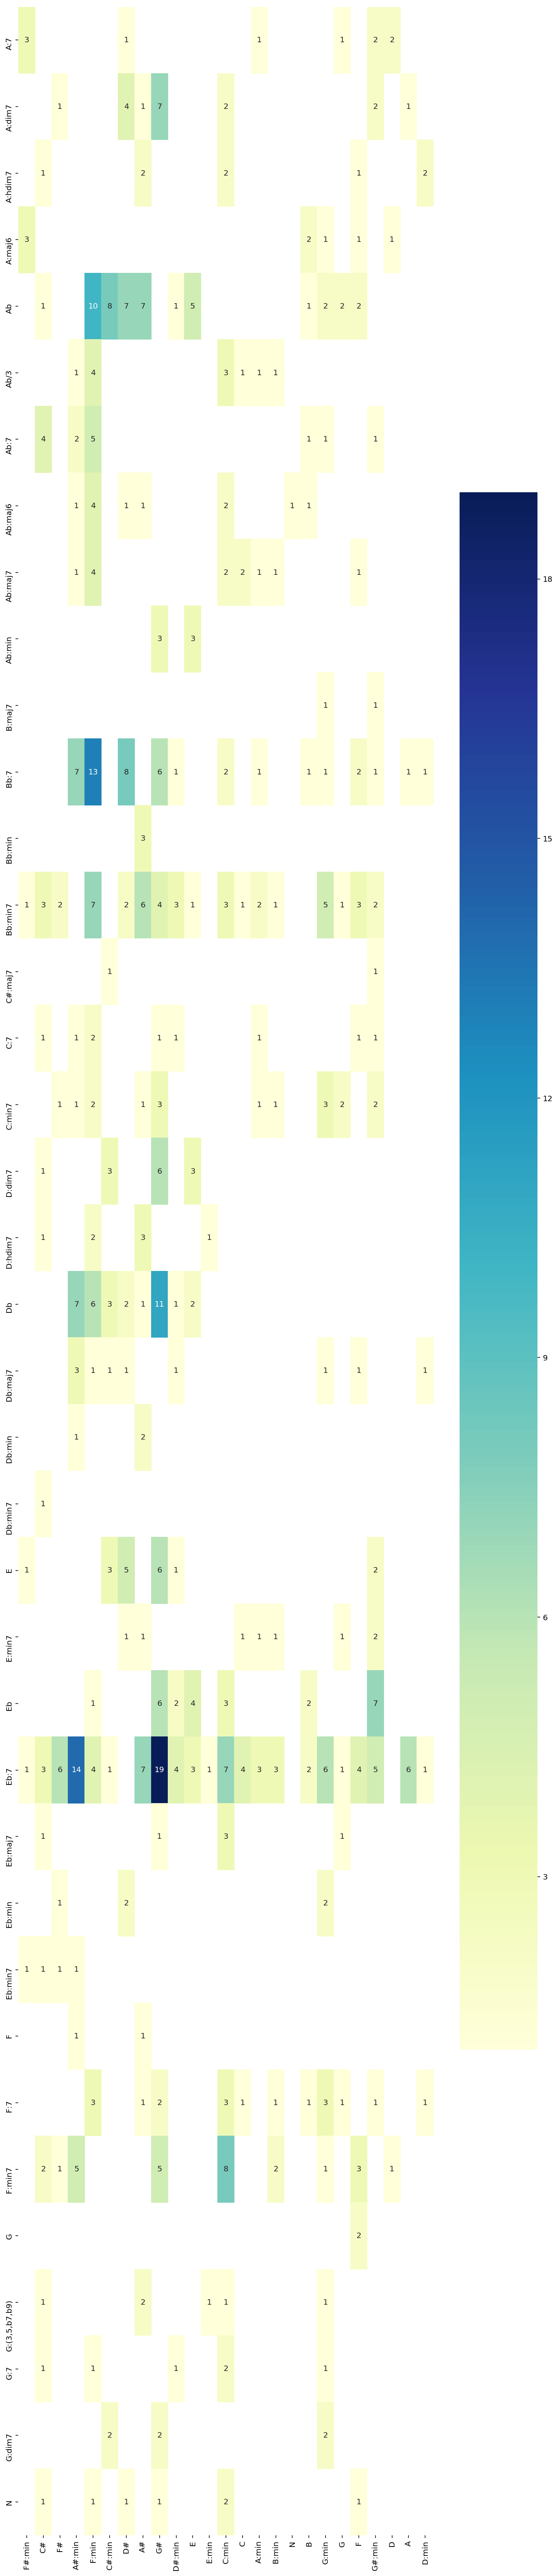

In [21]:
figure_beat = makebigheatmap(df_result_beat)
figure_beat.savefig('heatmap_beat.png', dpi=200)

In [22]:
chordnames_beat_all, mistakes_beat_all = find_mistakes_each_chord(df_result_beat)
with open('Top_errors_for_each_chord_beat.txt', 'w') as outfile:
    for j in range(len(chordnames_beat_all)):
        ##Output as json format
        #json.dump(chordnames_beat_all[j], outfile)
        #json.dump(str(mistakes_beat_all[j]), outfile)
        ##Output as txt format
        outfile.write(chordnames_beat_all[j]+'\n')
        outfile.write(str(mistakes_beat_all[j])+'\n')
        print(chordnames_beat_all[j], mistakes_beat_all[j])

A:7 ['F#:min' 'D' 'G#:min' 'G' 'A:min' 'D#']
A:dim7 ['G#' 'D#' 'G#:min' 'C:min' 'A' 'A#' 'F#']
A:hdim7 ['D:min' 'C:min' 'A#' 'F' 'C#']
A:maj6 ['F#:min' 'B' 'D' 'F' 'G:min']
Ab ['F:min' 'C#:min' 'A#' 'D#' 'E' 'F' 'G' 'G:min' 'B' 'D#:min' 'C#']
Ab/3 ['F:min' 'C:min' 'B:min' 'A:min' 'C' 'A#:min']
Ab:7 ['F:min' 'C#' 'A#:min' 'G#:min' 'G:min' 'B']
Ab:maj6 ['F:min' 'C:min' 'B' 'N' 'A#' 'D#' 'A#:min']
Ab:maj7 ['F:min' 'C' 'C:min' 'F' 'B:min' 'A:min' 'A#:min']
Ab:min ['E' 'G#']
B:maj7 ['G#:min' 'G:min']
Bb:7 ['F:min' 'D#' 'A#:min' 'G#' 'F' 'C:min' 'D:min' 'A' 'G#:min' 'G:min' 'B'
 'A:min' 'D#:min']
Bb:min ['A#']
Bb:min7 ['F:min' 'A#' 'G:min' 'G#' 'C#' 'C:min' 'F' 'D#:min' 'G#:min' 'D#' 'F#'
 'A:min' 'E' 'C' 'B:min' 'G' 'F#:min']
C#:maj7 ['G#:min' 'C#:min']
C:7 ['F:min' 'G#:min' 'F' 'A:min' 'D#:min' 'G#' 'A#:min' 'C#']
C:min7 ['G:min' 'G#' 'G#:min' 'G' 'F:min' 'B:min' 'A:min' 'A#' 'A#:min' 'F#']
D:dim7 ['G#' 'E' 'C#:min' 'C#']
D:hdim7 ['A#' 'F:min' 'E:min' 'C#']
Db ['G#' 'A#:min' 'F:min' 'C#:mi

Analyze chord detection algorithm by frame:

In [23]:
#Overall top 20 errors for algorithm by frame
rank_frame, df_result_frame = convert_dict(dict_comparelabels_frame_all, dict_foreachchord_frame_all)

#Save top 20 in csv file
rank_frame = rank_frame.iloc[:20]
rank_frame.to_csv(r'Top_errors_overall_frame.csv')

##Save in txt file
#with open('Top_errors_overall_frame.txt', 'w') as outfile:
#    for rownum in range(0, 21):
#        temprow = rank_frame.iloc[rownum]
#        outfile.write(temprow["chord pairs"])
#        outfile.write(str(temprow["count"])+'\n')


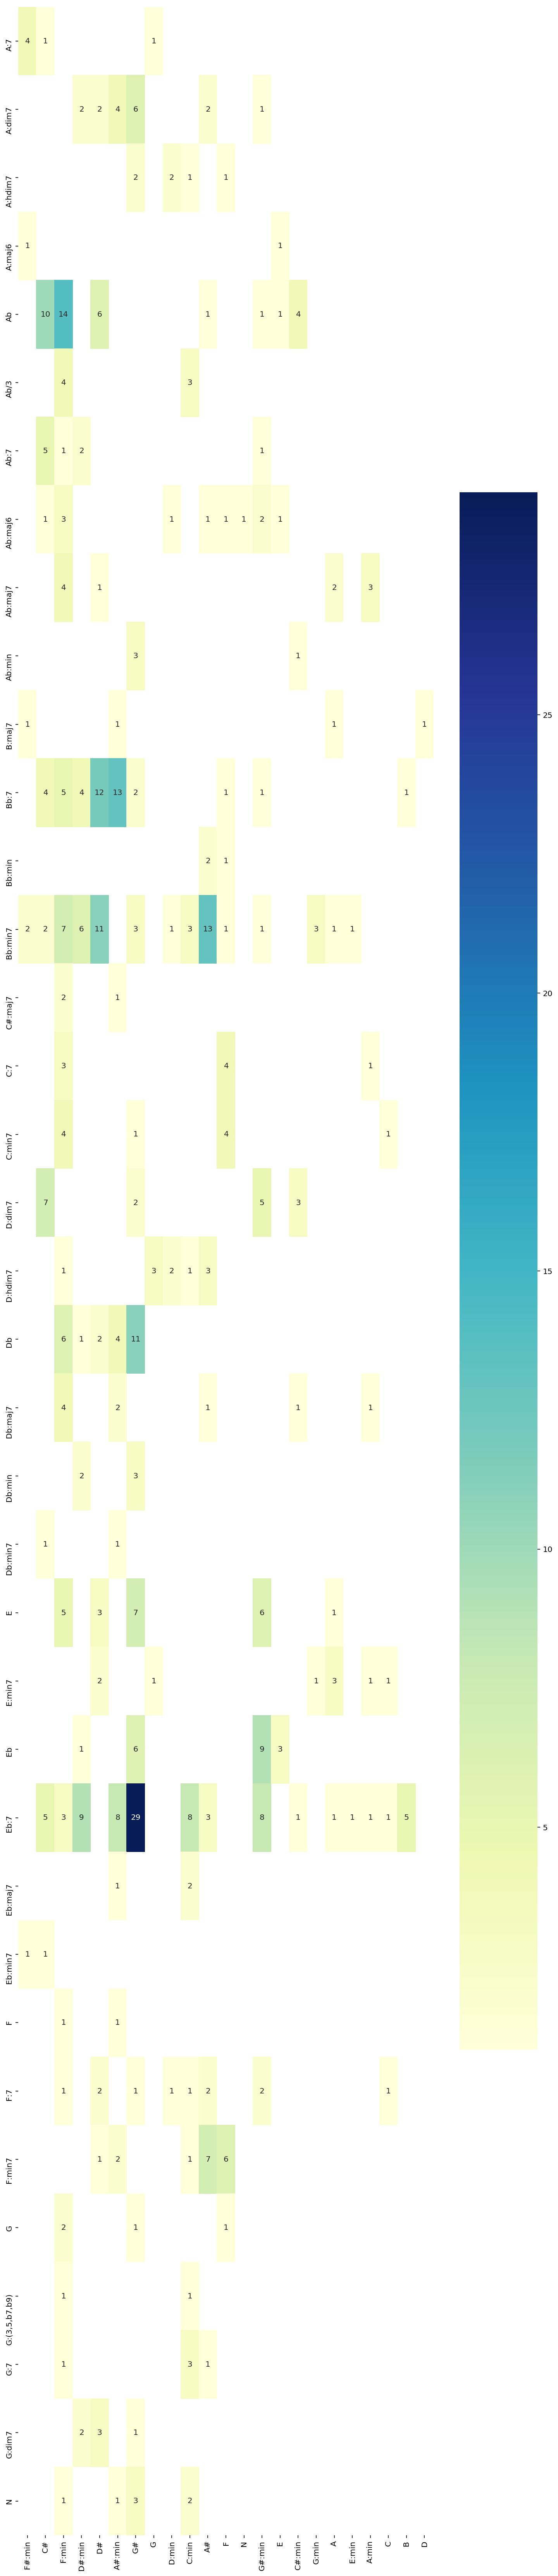

In [24]:
figure_frame = makebigheatmap(df_result_frame)
figure_frame.savefig('heatmap_frame.png', dpi=200)

In [25]:
chordnames_frame_all, mistakes_frame_all = find_mistakes_each_chord(df_result_frame)
with open('Top_errors_for_each_chord_frame.txt', 'w') as outfile:
    for j in range(len(chordnames_frame_all)):
        ##Output as json format
        #json.dump(chordnames_frame_all[j], outfile)
        #json.dump(str(mistakes_frame_all[j]), outfile)
        ##Output as txt format
        outfile.write(chordnames_frame_all[j]+'\n')
        outfile.write(str(mistakes_frame_all[j])+'\n')
        print(chordnames_frame_all[j], mistakes_frame_all[j])

A:7 ['F#:min' 'G' 'C#']
A:dim7 ['G#' 'A#:min' 'A#' 'D#' 'D#:min' 'G#:min']
A:hdim7 ['D:min' 'G#' 'F' 'C:min']
A:maj6 ['E' 'F#:min']
Ab ['F:min' 'C#' 'D#' 'C#:min' 'E' 'G#:min' 'A#']
Ab/3 ['F:min' 'C:min']
Ab:7 ['C#' 'D#:min' 'G#:min' 'F:min']
Ab:maj6 ['F:min' 'G#:min' 'E' 'N' 'F' 'A#' 'D:min' 'C#']
Ab:maj7 ['F:min' 'A:min' 'A' 'D#']
Ab:min ['G#' 'C#:min']
B:maj7 ['D' 'A' 'A#:min' 'F#:min']
Bb:7 ['A#:min' 'D#' 'F:min' 'D#:min' 'C#' 'G#' 'B' 'G#:min' 'F']
Bb:min ['A#' 'F']
Bb:min7 ['A#' 'D#' 'F:min' 'D#:min' 'G:min' 'C:min' 'G#' 'C#' 'F#:min' 'E:min' 'A'
 'G#:min' 'F' 'D:min']
C#:maj7 ['F:min' 'A#:min']
C:7 ['F' 'F:min' 'A:min']
C:min7 ['F' 'F:min' 'C' 'G#']
D:dim7 ['C#' 'G#:min' 'C#:min' 'G#']
D:hdim7 ['A#' 'G' 'D:min' 'C:min' 'F:min']
Db ['G#' 'F:min' 'A#:min' 'D#' 'D#:min']
Db:maj7 ['F:min' 'A#:min' 'A:min' 'C#:min' 'A#']
Db:min ['G#' 'D#:min']
Db:min7 ['A#:min' 'C#']
E ['G#' 'G#:min' 'F:min' 'D#' 'A']
E:min7 ['A' 'D#' 'C' 'A:min' 'G:min' 'G']
Eb ['G#:min' 'G#' 'E' 'D#:min']
Eb:7 ['G#

In [63]:
index = 0
for chordname in chordnames_frame_all:
    print("\nreal chordname:", chordname)
    for mistake in mistakes_frame_all[index]:
        difference = compute_chords_note_difference(chordname, mistake)
        if difference:
            print("\tmistaken for:", mistake, "\tdistance: ", difference)
    index+=1


real chordname: A:7
	mistaken for: F#:min 	distance:  3
	mistaken for: G 	distance:  5
	mistaken for: C# 	distance:  5

real chordname: A:dim7
	mistaken for: G# 	distance:  3
	mistaken for: A#:min 	distance:  7
	mistaken for: A# 	distance:  7
	mistaken for: D# 	distance:  5
	mistaken for: D#:min 	distance:  3
	mistaken for: G#:min 	distance:  5

real chordname: A:hdim7
	mistaken for: D:min 	distance:  5
	mistaken for: G# 	distance:  3
	mistaken for: F 	distance:  3
	mistaken for: C:min 	distance:  1

real chordname: A:maj6
	mistaken for: E 	distance:  5
	mistaken for: F#:min 	distance:  1

real chordname: Ab
	mistaken for: F:min 	distance:  2
	mistaken for: C# 	distance:  4
	mistaken for: D# 	distance:  4
	mistaken for: C#:min 	distance:  4
	mistaken for: E 	distance:  4
	mistaken for: G#:min 	distance:  2
	mistaken for: A# 	distance:  6

real chordname: Ab/3
	mistaken for: F:min 	distance:  2
	mistaken for: C:min 	distance:  2

real chordname: Ab:7
	mistaken for: C# 	distance:  5
	mi

In [57]:
#test
chordname = 'Ab/3'
mistake = 'F:min'
compute_chords_note_difference(chordname, mistake)

2

In [28]:
dict_comparelabels_beat_all

{"['A:7', 'A:min']": 1,
 "['A:7', 'D#']": 1,
 "['A:7', 'D']": 2,
 "['A:7', 'F#:min']": 3,
 "['A:7', 'G#:min']": 2,
 "['A:7', 'G']": 1,
 "['A:dim7', 'A#']": 1,
 "['A:dim7', 'A']": 1,
 "['A:dim7', 'C:min']": 2,
 "['A:dim7', 'D#']": 4,
 "['A:dim7', 'F#']": 1,
 "['A:dim7', 'G#']": 7,
 "['A:dim7', 'G#:min']": 2,
 "['A:hdim7', 'A#']": 2,
 "['A:hdim7', 'C#']": 1,
 "['A:hdim7', 'C:min']": 2,
 "['A:hdim7', 'D:min']": 2,
 "['A:hdim7', 'F']": 1,
 "['A:maj6', 'B']": 2,
 "['A:maj6', 'D']": 1,
 "['A:maj6', 'F#:min']": 3,
 "['A:maj6', 'F']": 1,
 "['A:maj6', 'G:min']": 1,
 "['Ab', 'A#']": 7,
 "['Ab', 'B']": 1,
 "['Ab', 'C#']": 1,
 "['Ab', 'C#:min']": 8,
 "['Ab', 'D#']": 7,
 "['Ab', 'D#:min']": 1,
 "['Ab', 'E']": 5,
 "['Ab', 'F']": 2,
 "['Ab', 'F:min']": 10,
 "['Ab', 'G']": 2,
 "['Ab', 'G:min']": 2,
 "['Ab/3', 'A#:min']": 1,
 "['Ab/3', 'A:min']": 1,
 "['Ab/3', 'B:min']": 1,
 "['Ab/3', 'C']": 1,
 "['Ab/3', 'C:min']": 3,
 "['Ab/3', 'F:min']": 4,
 "['Ab:7', 'A#:min']": 2,
 "['Ab:7', 'B']": 1,
 "['Ab:7', '

In [29]:
dict_foreachchord_frame_all


{'A:7': {'C#': 1, 'F#:min': 4, 'G': 1},
 'A:dim7': {'A#': 2, 'A#:min': 4, 'D#': 2, 'D#:min': 2, 'G#': 6, 'G#:min': 1},
 'A:hdim7': {'C:min': 1, 'D:min': 2, 'F': 1, 'G#': 2},
 'A:maj6': {'E': 1, 'F#:min': 1},
 'Ab': {'A#': 1,
  'C#': 10,
  'C#:min': 4,
  'D#': 6,
  'E': 1,
  'F:min': 14,
  'G#:min': 1},
 'Ab/3': {'C:min': 3, 'F:min': 4},
 'Ab:7': {'C#': 5, 'D#:min': 2, 'F:min': 1, 'G#:min': 1},
 'Ab:maj6': {'A#': 1,
  'C#': 1,
  'D:min': 1,
  'E': 1,
  'F': 1,
  'F:min': 3,
  'G#:min': 2,
  'N': 1},
 'Ab:maj7': {'A': 2, 'A:min': 3, 'D#': 1, 'F:min': 4},
 'Ab:min': {'C#:min': 1, 'G#': 3},
 'B:maj7': {'A': 1, 'A#:min': 1, 'D': 1, 'F#:min': 1},
 'Bb:7': {'A#:min': 13,
  'B': 1,
  'C#': 4,
  'D#': 12,
  'D#:min': 4,
  'F': 1,
  'F:min': 5,
  'G#': 2,
  'G#:min': 1},
 'Bb:min': {'A#': 2, 'F': 1},
 'Bb:min7': {'A': 1,
  'A#': 13,
  'C#': 2,
  'C:min': 3,
  'D#': 11,
  'D#:min': 6,
  'D:min': 1,
  'E:min': 1,
  'F': 1,
  'F#:min': 2,
  'F:min': 7,
  'G#': 3,
  'G#:min': 1,
  'G:min': 3},
 'C#: